In [131]:
import yfinance as yf
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product

In [19]:
# VPN USA für yfinance

# yfinance testen
isin = "CH0038863350"
ticker = yf.Ticker(isin)
print(ticker.info['longName'])
print(ticker.info['industry'])
print(ticker.info['currency'])
print(ticker.info['previousClose'])

Nestlé S.A.
Packaged Foods
CHF
99.02


In [18]:
test_list = ["CH0012221716", "CH0432492467", "CH0030170408", "CH0010645932", "CH0012214059", "CH0025238863", "CH0025751329", "CH0013841017", "CH0038863350", "CH0012005267",
        "CH0024608827", "CH0210483332", "CH0012032048", "CH0418792922", "CH0012549785", "CH0014852781", "CH0126881561", "CH0008742519", "CH0244767585", "CH0011075394",
        "CH0009002962", "CH0012142631", "CH0319416936", "CH0360674466"]

for item in test_list:
    ticker = yf.Ticker(item)
    print(ticker.info['longName'])

ABB Ltd
Alcon Inc.
Geberit AG
Givaudan SA
Holcim Ltd
Kuehne + Nagel International AG
Logitech International S.A.
Lonza Group AG
Nestlé S.A.
Novartis AG
Partners Group Holding AG
Compagnie Financière Richemont SA
Roche Holding AG
Sika AG
Sonova Holding AG
Swiss Life Holding AG
Swiss Re AG
Swisscom AG
UBS Group AG
Zurich Insurance Group AG
Barry Callebaut AG
Clariant AG
Flughafen Zürich AG
Galenica AG


In [183]:
class Investor:
    # Klassenattribute
    cio_sell_list = ['CH0010645932', 'CH0025238863', 'CH0025751329', 'CH0126881561']
    europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
    asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
    empty_market_allocation = {
        'United States': 0.,
        'Europe': 0.,
        'Switzerland': 0.,
        'Asia & EM': 0.
    }
    empty_sector_allocation = {
        'Financial Services': 0, 
        'Technology': 0., 
        'Industrials': 0., 
        'Energy': 0., 
        'Healthcare': 0., 
        'Consumer Defensive': 0., 
        'Consumer Cyclical': 0., 
        'Basic Materials': 0., 
        'Real Estate': 0., 
        'Communication Services': 0., 
        'Utilities': 0.,
        'Mixed': 0.
    }
    market_colors = {
        'United States': 'green',
        'Europe': 'royalblue',
        'Switzerland': 'red',
        'Asia & EM': 'pink'
    }
    sector_colors = {
        'Financial Services': 'lightblue', 
        'Technology': 'silver', 
        'Industrials': 'steelblue', 
        'Energy': 'orange', 
        'Healthcare': 'lightgreen', 
        'Consumer Defensive': 'tan', 
        'Consumer Cyclical': 'mediumpurple', 
        'Basic Materials': 'saddlebrown', 
        'Real Estate': 'maroon', 
        'Communication Services': 'gold', 
        'Utilities': 'teal',
        'Mixed': 'dimgrey'
    }
    # TO DO: Fetch forex data from API; currently hard-coded (suffices for current requirements)
    forex = {
        'CHF': 1.,
        'EUR': 0.9549,
        'USD': 0.9023,
        'GBP': 1.0953,
        'GBp': 0.010953, # ACHTUNG, GBp (auch manchmal GBX genannt) sind Pence Sterling (1 GBP = 100 GBp = 100 GBx)
        'NOK': 0.0808,
        'JPY': 0.00603,
        'HKD': 0.1153,
        'KRW': 0.00067,
        'TWD': 0.0278
    }

    def __init__(self, id, name, portfolio, investor_type, sector_bias='no_bias', investor_preference='dividends'):
        # Instanzattribute
        self._id = id
        self._name = name
        self._portfolio = portfolio
        self._investor_type = investor_type
        self._sector_bias = sector_bias
        self._investor_preference =  investor_preference
        self._portfolio_curreny = 'CHF'     # Momentan fix CHF
        self._portfolio_value = 0
        self._bulk_risks = []
        self._sell_stocks = []
        self._market_allocation = {}
        self._sector_allocation = {}
        self._market_allocation_difference = {}
        self._sector_allocation_difference = {}
        self._portfolio_beta = 0
        self._high_beta_stocks = []

    # Methoden
    def get_name(self):
        return f"Investor's name is {self._name}."

    def find_sell_stocks(self):
        # Portfolio durchsuchen nach Aktien, die auf der Sell-Liste sind
        for i in range(len(self._portfolio)):
            if self._portfolio[i]['isin'] in Investor.cio_sell_list and self._portfolio[i]['isin'] not in self._sell_stocks:
                self._sell_stocks.append(self._portfolio[i]['isin'])
                print(f"Attention! ISIN {self._portfolio[i]['isin']} is on the CIO 'Least Preferred' list.")
        if self._sell_stocks == []:
            print(f"No current positions in the portfolio are on the CIO 'Least Preferred' list.")

    def buy(self, isin, quantity):
        # Aktie kaufen

        # Überprüfen, ob ISIN existiert
        stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
        existing_isin = isin in stock_info['isin'].values
        if not existing_isin:
            return print(f'ISIN could not be found. Please check your input.')
        
        else:
            # print(f"Buying {quantity} units of ISIN {isin}...")

            # Checken, ob bereits im Portfolio
            already_bought = False
            for i in range(len(self._portfolio)): # Mehrfache Einträge der selben Aktie vermeiden; Position erhöhen
                if self._portfolio[i]['isin'] == isin: # Falls Position im Portfolio, vorhandene Position erhöhen
                    already_bought = True
                    print(f'Position already in portfolio, increasing quantity by {quantity}.')
                    self._portfolio[i]['quantity'] += quantity
                    print(f'Updated position: {self._portfolio[i]["quantity"]} units of ISIN {self._portfolio[i]["isin"]}')
                    break
            if already_bought == False: # Falls noch nicht im Portfolio, neue Position
                self._portfolio.append({'isin':isin, 'quantity':quantity})
                print(f'New position. Successfully bought {quantity} units of ISIN {isin}.')

            # print(f'Purchase successfully completed!')

    def sell(self, isin, quantity):
        # Aktie verkaufen
        for position in self._portfolio:
            if position['isin'] == isin and position['quantity'] >= quantity: # nur verkaufen wenn ISIN im Portfolio und genügend Einheiten
                position['quantity'] -= quantity
                print(f"Sold {quantity} units of ISIN {isin}.")
                if position['quantity'] == 0:
                    self._portfolio.remove(position)
                    print(f"Portfolio now holds 0 units of ISIN {isin}. Position removed.")
                self.fetch_portfolio_infos()
                return
        print(f"ISIN {isin} is not in the portfolio or there are fewer than {quantity} units in the portfolio.")


    def fetch_portfolio_infos(self):
        # aus stock_info Daten zu den Positionen fetchen & zuweisen
        print('Fetching data for each portfolio position.')
        stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
        # stock_info = stock_info.fillna(0)

        self._portfolio_value = 0

        for position in self._portfolio:
            # Infos zum relevanten Stock extrahieren
            info = stock_info.loc[stock_info['isin'] == position['isin'], ['isin', 'longName', 'previousClose', 'currency', 'country' , 'sector', 'industry', 'dividendYield', 'beta', 'trailingPE', '52WeekChange']] # zeile aus stock-info von dieser Aktie
            
            # Infos zuweisen
            position['name'] = info['longName'].values[0]       # Name
            position['currency'] = info['currency'].values[0]   # Währung
            if 'buy_price' not in position: # Kaufpreis, wird nur geschrieben, wenn davor keiner vorhanden war. Damit nicht bei späteren Updates überschrieben wird
                position['buy_price'] = round(info['previousClose'].values[0], 2) # Kaufpreis
            position['price'] = round(info['previousClose'].values[0], 2) # Preis
            position['value'] = round(position['quantity']*position['price']*Investor.forex[position['currency']], 2) # Wert = Anzahl*Preis*Wechselkurs
            self._portfolio_value += position['value']          # Gesamt-Portfoliowert aktualisieren
            position['sector'] = info['sector'].values[0]       # Sektor
            position['industry'] = info['industry'].values[0]   # Subsektor
            position['country'] = info['country'].values[0]     # Land
            position['dividend'] = info['dividendYield'].values[0]  # Dividende
            position['beta'] = info['beta'].values[0]               # Beta
            position['trailingPE'] = info['trailingPE'].values[0]   # PE
            position['52WeekChange'] = info['52WeekChange'].values[0] # Prozentuale Veränderung letzte 52 Wochen

            # Region für Allokation
            if position['country'] in Investor.europe_countries:
                position['region'] = 'Europe'
            elif position['country'] in Investor.asia_em_countries:
                position['region'] = 'Asia & EM'
            else:
                position['region'] = position['country'] # Switzerland & United States

        # Anteil am Portfoliowert für jede Position
        print('Updating portfolio percentage.')
        self._bulk_risks = []
        for position in self._portfolio:
            position['portfolio_percent'] = round(position['value']/self._portfolio_value, 4)
            if  position['portfolio_percent'] >= 0.1:
                self._bulk_risks.append(position['isin'])
                print(f"Bulk risk detected for ISIN {position['isin']}.")
        print('All infos fetched and positions updated.')
        print(f"Updated portfolio value: {self._portfolio_value}")

        # Bugfix: GBp auf GBP ändern
        for position in self._portfolio:
            if position['currency'] == 'GBp':
                position['currency'] = 'GBP'
                position['price'] = position['price']/100
                position['buy_price'] = position['buy_price']/100
        print('Fixed GBp')

    def calculate_allocation(self):
        # Berechnung der Markt- und Sektorallokation des Portfolios
        print('Calculating Market and Sector Allocation.')

        # Zuerst: Leere Allokation
        self._market_allocation = dict(Investor.empty_market_allocation)
        self._sector_allocation = dict(Investor.empty_sector_allocation)
        
        # Aggregation
        for position in self._portfolio:
            region = position['region']
            self._market_allocation[region] += position['portfolio_percent']
            sector = position['sector']
            self._sector_allocation[sector] += position['portfolio_percent']
        if self._sector_allocation['Mixed'] == 0:
            del self._sector_allocation['Mixed']
        print('Allocation successfully calculated.')

    def visualize_allocations(self, market=True, sector=True):
        # Allokation Visualisieren
        if market: # Markt Allokation
            market_label_list = []
            market_size_list = []
            market_color_list = []
            for market in self._market_allocation:
                if self._market_allocation[market] != 0: # Leere Werte rausnehmen für klarere Visualisierung
                    market_label_list.append(market)
                    market_size_list.append(self._market_allocation[market])
                    market_color_list.append(Investor.market_colors[market])

            plt.pie(x=market_size_list, labels=market_label_list, autopct='%1.1f%%', colors=market_color_list, wedgeprops=dict(edgecolor='black'))
            plt.title('Market Allocation')
            plt.show()

        if sector: # Sektor Allokation
            sector_label_list = []
            sector_size_list = []
            sector_color_list = []
            for sector in self._sector_allocation:
                if self._sector_allocation[sector] != 0:
                    sector_label_list.append(sector)
                    sector_size_list.append(self._sector_allocation[sector])
                    sector_color_list.append(Investor.sector_colors[sector])

            plt.pie(x=sector_size_list, labels=sector_label_list, autopct='%1.1f%%', colors=sector_color_list, wedgeprops=dict(edgecolor='black'))
            plt.title('Sector Allocation')
            plt.show()
    
    def calculate_allocation_difference(self):
        # Unterschied zwischen Kunden-Allokation und Benchmark-Allokation
        print(f'Comparing portfolio to benchmark allocation.')
        self._market_allocation_difference = dict(Investor.empty_market_allocation)
        self._sector_allocation_difference = dict(Investor.empty_sector_allocation)

        # print(f'Investor profile: {self._investor_type}')

        with open(f'..\data\profile_{self._investor_type}.json') as json_file:
            reference_allocation = json.load(json_file)

        for market in self._market_allocation:
            self._market_allocation_difference[market] = self._market_allocation[market] - reference_allocation['markets'][market]
        
        for sector in self._sector_allocation:
            self._sector_allocation_difference[sector] = self._sector_allocation[sector] - reference_allocation['sectors'][sector]
        print('Allocation differences were calculated successfully.')

    def visualize_allocation_differences(self, market=True, sector=True):
        # Allokations-Verletzungen visualisieren
        if market:
            market_diff_labels = []
            market_diff_sizes = []
            market_diff_colors = []
            for market in self._market_allocation_difference:
                market_diff_labels.append(market)
                market_diff_sizes.append(round(self._market_allocation_difference[market]*100, 2))
                market_diff_colors.append(Investor.market_colors[market])
            plt.figure(figsize=(6,6))
            plt.bar(x=market_diff_labels, height=market_diff_sizes, color=market_diff_colors)
            for i in range(len(market_diff_sizes)):
                plt.text(i, market_diff_sizes[i]//2, str(market_diff_sizes[i])+'%', ha = 'center')
            plt.xlabel('Market')
            plt.ylabel('Difference to Benchmark in %')
            plt.show

        if sector:
            sector_diff_labels = []
            sector_diff_sizes = []
            sector_diff_colors = []
            for sector in self._sector_allocation_difference:
                sector_diff_labels.append(sector)
                sector_diff_sizes.append(round(self._sector_allocation_difference[sector]*100, 2))
                sector_diff_colors.append(Investor.sector_colors[sector])
            plt.figure(figsize=(12,6))
            plt.bar(x=sector_diff_labels, height=sector_diff_sizes, color=sector_diff_colors)
            for i in range(len(sector_diff_sizes)):
                plt.text(i, sector_diff_sizes[i]//2, str(sector_diff_sizes[i])+'%', ha = 'center')
            plt.xlabel('Sector')
            plt.xticks(rotation=90)
            plt.ylabel('Difference to Benchmark in %')
            plt.show

    def print_portfolio(self):
        # Portfolio anzeigen
        if len(self._portfolio) == 0: # leeres Portfolio, abbrechen mit Nachricht
            return print('There are currently no positions in the portfolio.')
        if 'currency' not in self._portfolio[-1]: # Infos noch nicht gefetcht, abbrechen mit Nachricht
            return print('Please fetch stock info first.')
        
        print(f'Currency\tQuantity\tName\t\t\t\tISIN\t\tBuy Price\tMarket Price\tMarket Value')
        print(f'----------------------------------------------------------------------------------------------------------------------------')
        for position in self._portfolio:
            spaces = 30 - len(position['name'][:30])
            print(f"{position['currency']}\t\t{position['quantity']}\t\t{position['name'][:30]}{spaces*' '}\t{position['isin']}\t{position['buy_price']}\t\t{position['price']}\t\t{position['value']}")
            print(f'----------------------------------------------------------------------------------------------------------------------------')

    def calculate_portfolio_beta(self):
        """
        Grobe Risikoabschätzung, in Zukunft ersetzen mit Varianzberechnung
        """
        self._portfolio_beta = 0 # reset portfolio beta
        self._high_beta_stocks = []
        for position in self._portfolio:
            self._portfolio_beta += (position['beta']*position['portfolio_percent'])
            if position['beta'] >= 1.5:
                self._high_beta_stocks.append(position['isin'])
        self._portfolio_beta = round(self._portfolio_beta, 2)
        print(f"Updated Portfolio-Beta. It's currently at {self._portfolio_beta}")

    def random_portfolio(self):
        """
        To Do - Priority: 3
        """
        pass

    def write_json(self):
        json_object = json.dumps(self.__dict__, indent=4, ensure_ascii=False)
        id = self._id
        with open(f'{id}.json', 'w', encoding='utf-8') as outfile:
            json_object = json_object.replace("NaN", '"NaN"')
            outfile.write(json_object)
        print(f"Successfully created JSON file named {id}.json")
    
    def generate_json(self):
        json_object = json.dumps(self.__dict__, indent=4, ensure_ascii=False)
        json_object = json_object.replace("NaN", '"NaN"') # NaN Werte die beim Scraping verloren gehen ersetzen
        return json_object

    def __str__(self) -> str:
        return f"Investor's name is {self._name}."
    
    def __repr__(self):
        return f"{self._name}"

__________
## Start of Testing
__________

In [75]:
# Test: Random Investor
investors = []

def random_investor():
    rand_id = ''
    for i in range(6):
        rand_id+=(str(random.randint(0,9)))
    id ='000001'
    name = "Raphael"
    empty_portfolio = []

    investors.append(Investor(id, name, empty_portfolio, "swiss-bias"))

random_investor()
investors



[Raphael]

In [76]:
investors[0]._sell_stocks
investors[0]._portfolio
investors[0]._id
investors[0]._portfolio
# investors[0]._market_allocation
# investors[0]._bulk_risks

[]

In [77]:
# Test: Aktie kaufen
investors[0].buy(isin='CH0012005267', quantity=100)
print(investors[0]._portfolio)

New position. Successfully bought 100 units of ISIN CH0012005267.
[{'isin': 'CH0012005267', 'quantity': 100}]


In [26]:
# Test: andere Aktie kaufen
investors[0].buy(isin='CH0025751329', quantity=10)
print(investors[0]._portfolio)

Buying 10 units of ISIN CH0025751329...
New position.
Successfully bought 10 units of ISIN CH0025751329.
Purchase successfully completed!
[{'isin': 'CH0012005267', 'quantity': 100}, {'isin': 'CH0025751329', 'quantity': 10}]


In [9]:
# Test: einige Aktien kaufen
investors[0].buy(isin='JP3732000009', quantity=200)
investors[0].buy(isin='CH0025751329', quantity=50)
investors[0].buy(isin='US0378331005', quantity=15)
investors[0].buy(isin='US6541061031', quantity=15)
investors[0].buy(isin='US0378331005', quantity=15)
investors[0].buy(isin='FR0000121485', quantity=10)
investors[0].buy(isin='CH0011075394', quantity=10)
investors[0].buy(isin='CH0012214059', quantity=10)
investors[0].buy(isin='CH0030170408', quantity=15)
investors[0].buy(isin='IT0003128367', quantity=15)
investors[0].buy(isin='FR0000120073', quantity=10)
investors[0].buy(isin='DE0005557508', quantity=10)
investors[0].buy(isin='CH0038863350', quantity=15)
investors[0].buy(isin='CH0018294154', quantity=15)
investors[0].buy(isin='CH0012221716', quantity=10)
investors[0].buy(isin='CH0012032048', quantity=20)
investors[0].buy(isin='GB0009895292', quantity=15)
# investors[0].buy(isin='LU1169822779', quantity=15) # Fund, work in progress

Buying 200 units of ISIN JP3732000009...
New position.
Successfully bought 200 units of ISIN JP3732000009.
Purchase successfully completed!
Buying 50 units of ISIN CH0025751329...
Position already in portfolio, increasing quantity by 50.
Updated position: 60 units of ISIN CH0025751329
Purchase successfully completed!
Buying 15 units of ISIN US0378331005...
New position.
Successfully bought 15 units of ISIN US0378331005.
Purchase successfully completed!
Buying 15 units of ISIN US6541061031...
New position.
Successfully bought 15 units of ISIN US6541061031.
Purchase successfully completed!
Buying 15 units of ISIN US0378331005...
Position already in portfolio, increasing quantity by 15.
Updated position: 30 units of ISIN US0378331005
Purchase successfully completed!
Buying 10 units of ISIN FR0000121485...
New position.
Successfully bought 10 units of ISIN FR0000121485.
Purchase successfully completed!
Buying 10 units of ISIN CH0011075394...
New position.
Successfully bought 10 units of IS

In [10]:
investors[0]._portfolio

[{'isin': 'CH0012005267', 'quantity': 100},
 {'isin': 'CH0025751329', 'quantity': 60},
 {'isin': 'JP3732000009', 'quantity': 200},
 {'isin': 'US0378331005', 'quantity': 30},
 {'isin': 'US6541061031', 'quantity': 15},
 {'isin': 'FR0000121485', 'quantity': 10},
 {'isin': 'CH0011075394', 'quantity': 10},
 {'isin': 'CH0012214059', 'quantity': 10},
 {'isin': 'CH0030170408', 'quantity': 15},
 {'isin': 'IT0003128367', 'quantity': 15},
 {'isin': 'FR0000120073', 'quantity': 10},
 {'isin': 'DE0005557508', 'quantity': 10},
 {'isin': 'CH0038863350', 'quantity': 15},
 {'isin': 'CH0018294154', 'quantity': 15},
 {'isin': 'CH0012221716', 'quantity': 10},
 {'isin': 'CH0012032048', 'quantity': 20},
 {'isin': 'GB0009895292', 'quantity': 15}]

In [11]:
# Test: Sell-stocks identifizieren
investors[0].find_sell_stocks()

Attention! ISIN CH0025751329 is on the CIO 'Least Preferred' list.


In [12]:
# Test: Sell-Stocks ausgeben
investors[0]._sell_stocks

['CH0025751329']

In [13]:
# Test: Fetch_Portfolio_infos
investors[0].fetch_portfolio_infos()

Fetching data for each portfolio position.
Updating portfolio percentage.
Bulk risk detected for ISIN CH0012005267.
Bulk risk detected for ISIN CH0030170408.
Bulk risk detected for ISIN CH0012032048.
All infos fetched and positions updated.
Updated portfolio value: 48541.07000000001
Fixed GBp


In [14]:
# Test: Bulk Risks ausgeben
investors[0]._bulk_risks

['CH0012005267', 'CH0030170408', 'CH0012032048']

In [15]:
# Test: Portfolio ausgeben nach dem Fetch
investors[0]._portfolio

[{'isin': 'CH0012005267',
  'quantity': 100,
  'name': 'Novartis AG',
  'currency': 'CHF',
  'buy_price': 87.38,
  'price': 87.38,
  'value': 8738.0,
  'sector': 'Healthcare',
  'industry': 'Drug Manufacturers - General',
  'country': 'Switzerland',
  'dividend': 0.0366,
  'beta': 0.487394,
  'trailingPE': 26.710768,
  '52WeekChange': 0.13805676,
  'region': 'Switzerland',
  'portfolio_percent': 0.18},
 {'isin': 'CH0025751329',
  'quantity': 60,
  'name': 'Logitech International S.A.',
  'currency': 'CHF',
  'buy_price': 64.78,
  'price': 64.78,
  'value': 3886.8,
  'sector': 'Technology',
  'industry': 'Computer Hardware',
  'country': 'Switzerland',
  'dividend': 0.0164,
  'beta': 0.630634,
  'trailingPE': 35.53591,
  '52WeekChange': 0.47394764,
  'region': 'Switzerland',
  'portfolio_percent': 0.0801},
 {'isin': 'JP3732000009',
  'quantity': 200,
  'name': 'SoftBank Corp.',
  'currency': 'JPY',
  'buy_price': 1671.5,
  'price': 1671.5,
  'value': 2015.83,
  'sector': 'Communication 

In [16]:
investors[0]._portfolio_value

48541.07000000001

In [17]:
# Test: Allokationen berechnen
investors[0].calculate_allocation()

Calculating Market and Sector Allocation.
Allocation successfully calculated.


In [18]:
investors[0]._market_allocation
investors[0]._sector_allocation

{'Financial Services': 0.0888,
 'Technology': 0.17980000000000002,
 'Industrials': 0.14370000000000002,
 'Energy': 0.0,
 'Healthcare': 0.3221,
 'Consumer Defensive': 0.032,
 'Consumer Cyclical': 0.1091,
 'Basic Materials': 0.0432,
 'Real Estate': 0.0341,
 'Communication Services': 0.0455,
 'Utilities': 0.0017}

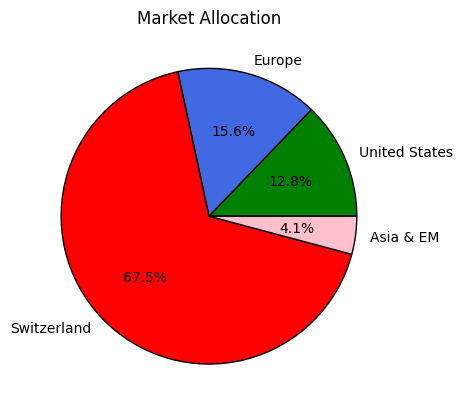

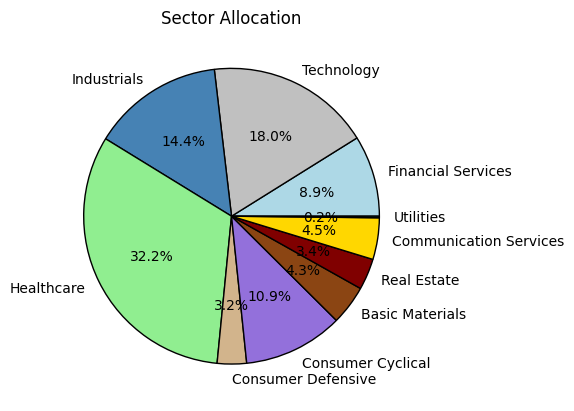

In [19]:
# Testing: Allokation visualisieren
investors[0].visualize_allocations()

In [20]:
investors[0].calculate_allocation_difference()

Comparing portfolio to benchmark allocation.
Investor profile: swiss-bias
Allocation differences were calculated successfully.


In [21]:
investors[0]._market_allocation_difference

{'United States': -0.021799999999999986,
 'Europe': 0.03570000000000001,
 'Switzerland': -0.025399999999999867,
 'Asia & EM': 0.011500000000000003}

In [22]:
investors[0]._sector_allocation_difference

{'Financial Services': -0.09119999999999999,
 'Technology': 0.09980000000000001,
 'Industrials': -0.006299999999999972,
 'Energy': -0.02,
 'Healthcare': 0.0821,
 'Consumer Defensive': -0.118,
 'Consumer Cyclical': 0.0291,
 'Basic Materials': -0.0068000000000000005,
 'Real Estate': 0.0341,
 'Communication Services': 0.0155,
 'Utilities': -0.0183,
 'Mixed': 0.0}

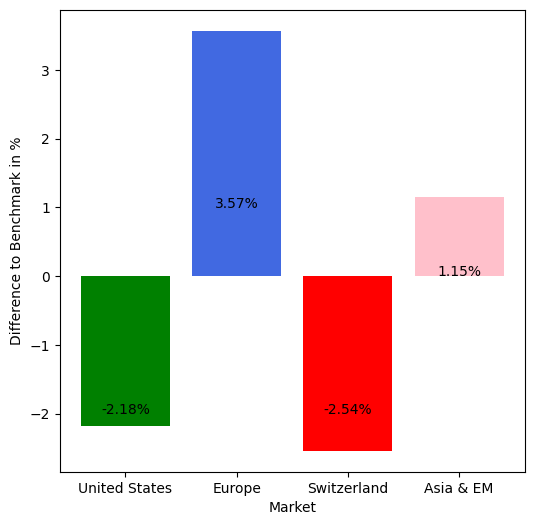

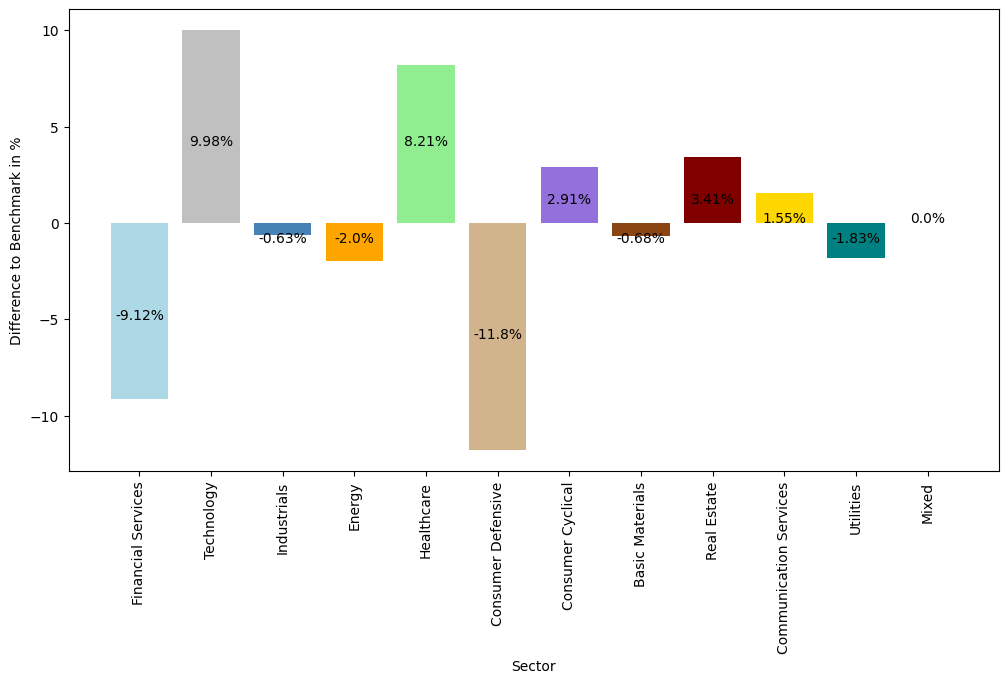

In [23]:
investors[0].visualize_allocation_differences()

In [24]:
investors[0].print_portfolio()

Currency	Quantity	Name				ISIN		Buy Price	Market Price	Market Value
----------------------------------------------------------------------------------------------------------------------------
CHF		100		Novartis AG                   	CH0012005267	87.38		87.38		8738.0
----------------------------------------------------------------------------------------------------------------------------
CHF		60		Logitech International S.A.   	CH0025751329	64.78		64.78		3886.8
----------------------------------------------------------------------------------------------------------------------------
JPY		200		SoftBank Corp.                	JP3732000009	1671.5		1671.5		2015.83
----------------------------------------------------------------------------------------------------------------------------
USD		30		Apple Inc.                    	US0378331005	178.72		178.72		4837.77
----------------------------------------------------------------------------------------------------------------------------
USD

In [25]:
investors[0].calculate_portfolio_beta()

Updated Portfolio-Beta. It's currently at 0.65


In [26]:
print(investors[0]._high_beta_stocks)

[]


In [27]:
investors[0].sell(isin='CH0012005267', quantity=1)

Sold 1 units of ISIN CH0012005267.
Fetching data for each portfolio position.
Updating portfolio percentage.
Bulk risk detected for ISIN CH0012005267.
Bulk risk detected for ISIN CH0030170408.
Bulk risk detected for ISIN CH0012032048.
All infos fetched and positions updated.
Updated portfolio value: 48453.69000000001
Fixed GBp


In [28]:
investors[0].write_json()

Successfully created JSON file named 000001.json


__________________
## Personas & Bias
__________________

In [78]:
def build_dummy_investor(dummy_id:str, dummy_name:str, dummy_investor_type:str, dummy_sector_bias:str, dummy_investor_preference:str):
    investor = Investor(id=dummy_id, name=dummy_name, portfolio=[], investor_type=dummy_investor_type, sector_bias=dummy_sector_bias, investor_preference=dummy_investor_preference)
    basic_portfolio = {
        'CH0038863350': 690, # Nestle
        'CH0012005267': 810, # Novartis
        'CH0012032048': 275, # Roche
        'CH0012221716':1500, # ABB
        'CH0011075394': 170, # Zurich Insurance
        'CH0030170408': 100, # Geberit
        'CH0008742519':  80, # Swisscom
        'CH0012214059': 800, # Holcim
        'FR0000121014':  60, # LVMH
        'FR0000120321': 110, # L'Oreal
        'FR0000120271': 600, # TotalEnergies
        'US0378331005': 210, # Apple
        'US5949181045': 105, # Microsoft
        'US92826C8394': 150  # Visa
    }

    bias_dict = {}

    it_bias = {
        'US67066G1040': 170, # Nvidia
        'CH0025751329':1250, # Logitech
        'DE0007164600': 700, # SAP
        'KYG875721634':2400, # Tencent
        'US0378331005': 300, # Apple Basis aufstocken
        'US5949181045': 170, # Microsoft Basis aufstocken
    }

    finance_bias = {
        'CH0102484968': 1400, # Julius Baer
        'DE0008404005':  380, # Allianz
        'GB0031348658':48000, # Barclays
        'FR0000131104': 1500, # BNP Paribas
        'US92826C8394':  220, # Visa Basis aufstocken
    }

    fashion_bias = {
        'ES0148396007':2400, # Inditex
        'US6541061031': 900, # Nike
        'US7512121010': 800, # Ralph Lauren
        'FR0000121014':  70, # LVMH Basis aufstocken
    }

    industrial_bias = {
        'CH0030170408':  80, # Geberit Basis aufstocken
        'FR0000125486': 820, # Vinci
        'US2910111044': 950, # Emmerson Electric
        'CH0012221716': 950, # ABB Basis aufstocken
    }

    car_bias = {
        'JP3633400001':5000, # Toyota
        'NL00150001Q9':4600, # Stellantis
        'NL0011585146': 290, # Ferrari
    }

    risk_bias = {
        'GB00B7KR2P84':20000, # easyJet
        'NL0011821202': 3400, # ING
        'US67066G1040':  100, # NVIDIA
        'DE0006231004': 1300, # Infineon
        'FR0000131104':  800, # BNP Paribas
        'US0079031078':  420, # AMD
    }

    no_bias = {}

    bias_dict['it_bias'] = it_bias
    bias_dict['finance_bias'] = finance_bias
    bias_dict['fashion_bias'] = fashion_bias
    bias_dict['industrial_bias'] = industrial_bias
    bias_dict['car_bias'] = car_bias
    bias_dict['risk_bias'] = risk_bias
    bias_dict['no_bias'] = no_bias

    # Basic Portfolio
    for key, value in basic_portfolio.items():
        investor.buy(isin=key, quantity=value)

    # Bias
    for key, value in bias_dict[dummy_sector_bias].items():
        investor.buy(isin=key, quantity=value)

    investor.find_sell_stocks()
    investor.fetch_portfolio_infos()
    investor.calculate_allocation()
    investor.calculate_allocation_difference()
    investor.calculate_portfolio_beta()
    investor.write_json()

    return investor

In [181]:
dummy_info = {'000001':['Lenny Linux', 'swiss-bias', 'it_bias', 'performance'], 
              '000002':['Benny Banker', 'swiss-global', 'finance_bias', 'dividends'], 
              '000003':['Louise Vuitton', 'global', 'fashion_bias', 'low_volatility'], 
              '000004':['Robby Robotic', 'swiss-bias', 'industrial_bias', 'low_pe'], 
              '000005':['Freddy Ferrari', 'swiss-global', 'car_bias', 'performance'], 
              '000006':['Ricky Risk', 'global', 'risk_bias', 'performance']
              }

dummy_investors = []

for id in dummy_info:
    name = dummy_info[id][0]
    investor_type = dummy_info[id][1]
    sector_bias = dummy_info[id][2]
    investor_preference = dummy_info[id][3]
    investor = build_dummy_investor(dummy_id=id, dummy_name=name, dummy_investor_type=investor_type, 
                         dummy_sector_bias=sector_bias, dummy_investor_preference=investor_preference)
    dummy_investors.append(investor)
dummy_investors

New position. Successfully bought 690 units of ISIN CH0038863350.
New position. Successfully bought 810 units of ISIN CH0012005267.
New position. Successfully bought 275 units of ISIN CH0012032048.
New position. Successfully bought 1500 units of ISIN CH0012221716.
New position. Successfully bought 170 units of ISIN CH0011075394.
New position. Successfully bought 100 units of ISIN CH0030170408.
New position. Successfully bought 80 units of ISIN CH0008742519.
New position. Successfully bought 800 units of ISIN CH0012214059.
New position. Successfully bought 60 units of ISIN FR0000121014.
New position. Successfully bought 110 units of ISIN FR0000120321.
New position. Successfully bought 600 units of ISIN FR0000120271.
New position. Successfully bought 210 units of ISIN US0378331005.
New position. Successfully bought 105 units of ISIN US5949181045.
New position. Successfully bought 150 units of ISIN US92826C8394.
New position. Successfully bought 170 units of ISIN US67066G1040.
New positio

[Lenny Linux,
 Benny Banker,
 Louise Vuitton,
 Robby Robotic,
 Freddy Ferrari,
 Ricky Risk]

In [44]:
build_dummy_investor(dummy_id='000003', dummy_name='Lenny Linux', dummy_investor_type='swiss-bias', 
                     dummy_sector_bias='it_bias', dummy_investor_preference='performance')

Buying 690 units of ISIN CH0038863350...
New position.
Successfully bought 690 units of ISIN CH0038863350.
Purchase successfully completed!
Buying 810 units of ISIN CH0012005267...
New position.
Successfully bought 810 units of ISIN CH0012005267.
Purchase successfully completed!
Buying 275 units of ISIN CH0012032048...
New position.
Successfully bought 275 units of ISIN CH0012032048.
Purchase successfully completed!
Buying 1500 units of ISIN CH0012221716...
New position.
Successfully bought 1500 units of ISIN CH0012221716.
Purchase successfully completed!
Buying 170 units of ISIN CH0011075394...
New position.
Successfully bought 170 units of ISIN CH0011075394.
Purchase successfully completed!
Buying 100 units of ISIN CH0030170408...
New position.
Successfully bought 100 units of ISIN CH0030170408.
Purchase successfully completed!
Buying 80 units of ISIN CH0008742519...
New position.
Successfully bought 80 units of ISIN CH0008742519.
Purchase successfully completed!
Buying 800 units of 

Lenny Linux

In [33]:
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
selected_columns = ['longName', 'beta']
sorted_stock_info = stock_info[selected_columns].sort_values(by='beta', ascending=False)
print(sorted_stock_info.head(20))

                         longName      beta
70                    easyJet plc  2.506493
49                 ING Groep N.V.  1.694000
108            NVIDIA Corporation  1.684000
48       Infineon Technologies AG  1.676000
38                 BNP Paribas SA  1.652000
96   Advanced Micro Devices, Inc.  1.648000
61               UniCredit S.p.A.  1.604000
100       Applied Materials, Inc.  1.581000
25           Julius Bär Gruppe AG  1.504965
82       Ralph Lauren Corporation  1.430000
104      Marvell Technology, Inc.  1.399930
65        Heidelberg Materials AG  1.367000
90           Emerson Electric Co.  1.367000
76                Norsk Hydro ASA  1.366310
36          Banco Santander, S.A.  1.361000
68                   Barclays PLC  1.353000
35                         AXA SA  1.338000
71                   Glencore plc  1.320473
81        The Walt Disney Company  1.310000
59                Stellantis N.V.  1.308000


In [34]:
anzahl_aktien_mit_beta_ueber_1 = len(stock_info[stock_info['beta'] > 1])
anzahl_aktien_mit_beta_unter_1 = len(stock_info[stock_info['beta'] < 1])
print(f'Anzahl Aktien mit Beta über 1:  {anzahl_aktien_mit_beta_ueber_1}')
print(f'Anzahl Aktien mit Beta unter 1: {anzahl_aktien_mit_beta_unter_1}')

Anzahl Aktien mit Beta über 1:  50
Anzahl Aktien mit Beta unter 1: 75


In [35]:
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
selected_columns = ['isin', 'longName', 'country', 'sector', 'beta']
reduced_stock_info = stock_info[selected_columns]

europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
reduced_stock_info.loc[reduced_stock_info['country'].isin(europe_countries), 'country'] = 'Europe'
reduced_stock_info.loc[reduced_stock_info['country'].isin(asia_em_countries), 'country'] = 'Asia & EM'

reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['country']=='Asia & EM']
reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['sector']=='Financial Services']
reduced_stock_info


,isin,longName,country,sector,beta
116,JP3890350006,"Sumitomo Mitsui Financial Group, Inc.",Asia & EM,Financial Services,0.742655
122,HK0000069689,AIA Group Limited,Asia & EM,Financial Services,0.910236


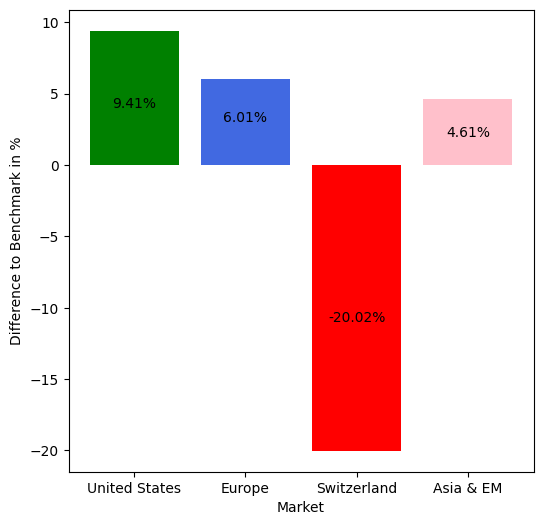

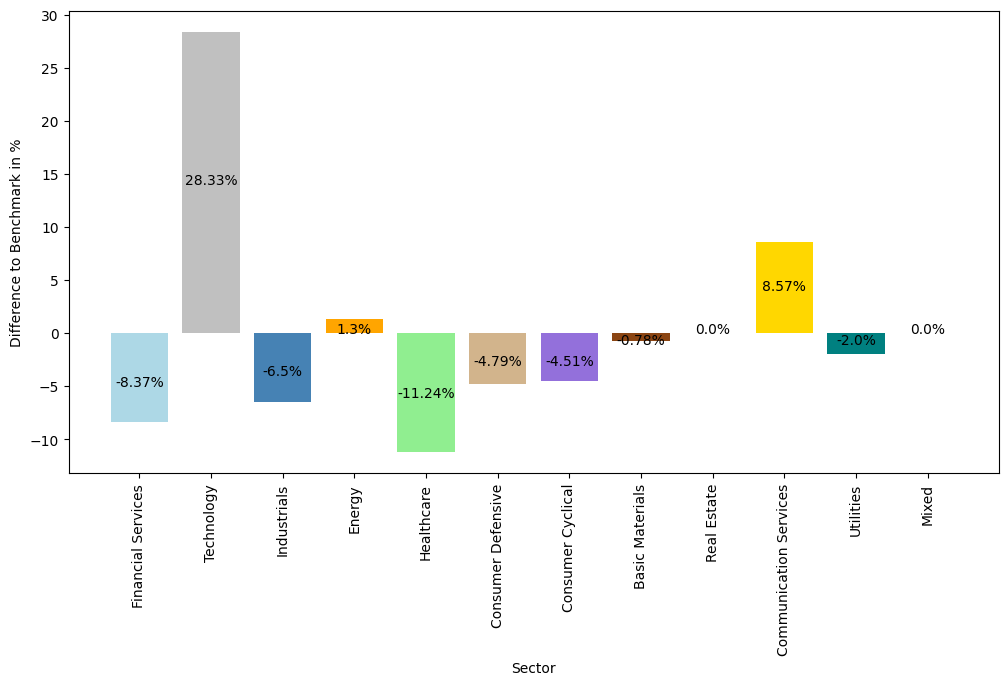

In [83]:
dummy_investors[0].visualize_allocation_differences()

In [141]:
dummy_investors[0]._portfolio_beta = 0

In [142]:
# TO DO: Wenn Aktie im Portfolio >= 5%, nicht empfehlen wegen Bulk Risk
# TO DO: Liste der 3 grössten "Löcher" identifizieren, also Markt+Sektor
# TO DO: Wenn Vorschlag zu wenige Aktien enthält, zweitgrösstes Loch nehmen für zusätzliche Vorschläge
# TO DO: Entscheiden, ob nur Vorschläge zu grösstem Loch oder Mix für Diversity

preferences = ['dividends', 'low_pe', 'low_volatility', 'performance']

stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
selected_columns = ['isin', 'longName', 'country', 'sector', 'beta', 'dividendYield', 'trailingPE', '52WeekChange']
reduced_stock_info = stock_info[selected_columns]

europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
reduced_stock_info.loc[reduced_stock_info['country'].isin(europe_countries), 'country'] = 'Europe'
reduced_stock_info.loc[reduced_stock_info['country'].isin(asia_em_countries), 'country'] = 'Asia & EM'

biggest_market_underweight = min(dummy_investors[0]._market_allocation_difference, key=dummy_investors[0]._market_allocation_difference.get)
bigest_sector_underweight = min(dummy_investors[0]._sector_allocation_difference, key=dummy_investors[0]._sector_allocation_difference.get)

reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['country'] == biggest_market_underweight]
reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['sector'] == bigest_sector_underweight]

# Wenn Portfolio-Beta zu hoch, nur noch Aktien mit tiefem Beta empfehlen
if dummy_investors[0]._portfolio_beta > 0.95 or dummy_investors[0]._investor_preference == 'low_volatility':
    reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['beta'] <= 0.8]
    reduced_stock_info = reduced_stock_info.sort_values(by='beta', ascending=True)
elif dummy_investors[0]._investor_preference == 'dividends':
    reduced_stock_info = reduced_stock_info.sort_values(by='dividendYield', ascending=False)
elif dummy_investors[0]._investor_preference == 'low_pe':
    reduced_stock_info = reduced_stock_info.sort_values(by='trailingPE', ascending=True)  
elif dummy_investors[0]._investor_preference == 'performance':
    reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['52WeekChange'] >= -0.1]
    reduced_stock_info = reduced_stock_info.sort_values(by='52WeekChange', ascending=False)
reduced_stock_info.reset_index(drop=True, inplace=True)  

print('Vorschlag Something Essential')
print(f'Präferenz: {dummy_investors[0]._investor_preference} --> sortiere nach diesem Kriterium')
reduced_stock_info

Vorschlag Something Essential
Präferenz: performance --> sortiere nach diesem Kriterium


,isin,longName,country,sector,beta,dividendYield,trailingPE,52WeekChange
0,CH0432492467,Alcon Inc.,Switzerland,Healthcare,0.684096,0.0031,100.818180,0.149218
1,CH0012005267,Novartis AG,Switzerland,Healthcare,0.487394,0.0366,26.710768,0.138057
2,CH0360674466,Galenica AG,Switzerland,Healthcare,0.211993,0.0327,20.527950,-0.048886
3,CH0012549785,Sonova Holding AG,Switzerland,Healthcare,0.960656,0.0210,20.102709,-0.054609


In [138]:
# Kombinationen von Märkten und Sektoren mit grösstem Handlungsbedarf finden
key_pairs = list(product(dummy_investors[0]._market_allocation_difference.keys(), dummy_investors[0]._sector_allocation_difference.keys()))
sum_values = {pair: dummy_investors[0]._market_allocation_difference[pair[0]] + dummy_investors[0]._sector_allocation_difference[pair[1]] for pair in key_pairs}

# Sortieren nach Grösse
top_pairs = sorted(sum_values.items(), key=lambda x: x[1], reverse=False)[:10]
top_pairs

[(('Switzerland', 'Healthcare'), -0.31259999999999993),
 (('Switzerland', 'Financial Services'), -0.28389999999999993),
 (('Switzerland', 'Industrials'), -0.26519999999999994),
 (('Switzerland', 'Consumer Defensive'), -0.24809999999999993),
 (('Switzerland', 'Consumer Cyclical'), -0.24529999999999993),
 (('Switzerland', 'Utilities'), -0.22019999999999992),
 (('Switzerland', 'Basic Materials'), -0.20799999999999993),
 (('Switzerland', 'Real Estate'), -0.20019999999999993),
 (('Switzerland', 'Mixed'), -0.20019999999999993),
 (('Switzerland', 'Energy'), -0.18719999999999992)]

In [177]:
def prepare_reduced_stock_info():
    stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t') # TSV als Pandas-df
    selected_columns = ['isin', 'longName', 'country', 'sector', 'beta', 'dividendYield', 'trailingPE', '52WeekChange']
    reduced_stock_info = stock_info[selected_columns]

    europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
    asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
    reduced_stock_info.loc[reduced_stock_info['country'].isin(europe_countries), 'country'] = 'Europe'
    reduced_stock_info.loc[reduced_stock_info['country'].isin(asia_em_countries), 'country'] = 'Asia & EM'
    return reduced_stock_info

# Kombinationen von Märkten und Sektoren mit grösstem Handlungsbedarf finden
key_pairs = list(product(dummy_investors[0]._market_allocation_difference.keys(), dummy_investors[0]._sector_allocation_difference.keys()))
sum_values = {pair: dummy_investors[0]._market_allocation_difference[pair[0]] + dummy_investors[0]._sector_allocation_difference[pair[1]] for pair in key_pairs}

# Sortieren nach Grösse
top_pairs = sorted(sum_values.items(), key=lambda x: x[1], reverse=False)[:10]

recommendations = []
counter = 5

for i in range(5):
    reduced_stock_info = prepare_reduced_stock_info()
    if counter > 0:
        if i == 0:
            number_recommended = 3
        else:
            number_recommended = 1

        country = top_pairs[i][0][0]
        sector = top_pairs[i][0][1]

        reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['country'] == country]
        reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['sector'] == sector]

        # Wenn Portfolio-Beta zu hoch, nur noch Aktien mit tiefem Beta empfehlen
        if dummy_investors[0]._portfolio_beta > 0.95 or dummy_investors[0]._investor_preference == 'low_volatility':
            reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['beta'] <= 0.8]
            reduced_stock_info = reduced_stock_info.sort_values(by='beta', ascending=True)
            recommendation_text = 'low volatility'

        elif dummy_investors[0]._investor_preference == 'dividends':
            reduced_stock_info = reduced_stock_info.sort_values(by='dividendYield', ascending=False)
            recommendation_text = 'high dividends'

        elif dummy_investors[0]._investor_preference == 'low_pe':
            reduced_stock_info = reduced_stock_info.sort_values(by='trailingPE', ascending=True)
            recommendation_text = 'low P/E ratio'

        elif dummy_investors[0]._investor_preference == 'performance':
            reduced_stock_info = reduced_stock_info.loc[reduced_stock_info['52WeekChange'] >= -0.1]
            reduced_stock_info = reduced_stock_info.sort_values(by='52WeekChange', ascending=False)
            recommendation_text = '1-year performace'

        reduced_stock_info.reset_index(drop=True, inplace=True)

        possible_reccomendations = len(reduced_stock_info)

        for j in range(min(possible_reccomendations, number_recommended)):
            recommendations.append([])
            counter -=1
        




print('Vorschlag Something Essential')
print(f'Präferenz: {dummy_investors[0]._investor_preference} --> sortiere nach diesem Kriterium')
# reduced_stock_info

0
0
0
1
2
Vorschlag Something Essential
Präferenz: performance --> sortiere nach diesem Kriterium


In [184]:
top_pairs

[(('Switzerland', 'Healthcare'), -0.31259999999999993),
 (('Switzerland', 'Financial Services'), -0.28389999999999993),
 (('Switzerland', 'Industrials'), -0.26519999999999994),
 (('Switzerland', 'Consumer Defensive'), -0.24809999999999993),
 (('Switzerland', 'Consumer Cyclical'), -0.24529999999999993),
 (('Switzerland', 'Utilities'), -0.22019999999999992),
 (('Switzerland', 'Basic Materials'), -0.20799999999999993),
 (('Switzerland', 'Real Estate'), -0.20019999999999993),
 (('Switzerland', 'Mixed'), -0.20019999999999993),
 (('Switzerland', 'Energy'), -0.18719999999999992)]

In [174]:
reduced_stock_info = prepare_reduced_stock_info()
new = reduced_stock_info[reduced_stock_info['sector']=='Consumer Defensive']
new = new[new['country']=='United States']
new

,isin,longName,country,sector,beta,dividendYield,trailingPE,52WeekChange
80,US9311421039,Walmart Inc.,United States,Consumer Defensive,0.538,0.0141,31.042309,0.206788
86,US7427181091,The Procter & Gamble Company,United States,Consumer Defensive,0.465,0.0257,24.831919,0.128898


In [172]:
min(1,2)

1

__________
## End of Testing
__________

In [39]:
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t')
cio_sell_list = ['CH0010645932', 'CH0025238863', 'CH0025751329', 'CH0126881561']
europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland', 'Europe']
asia_em_countries = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan', 'Asia & EM']
forex = {
    'CHF': 1.,
    'EUR': 0.9549,
    'USD': 0.9023,
    'GBP': 1.0953,
    'GBp': 0.010953, # ACHTUNG, GBp (auch manchmal GBX genannt) sind Pence Sterling (1 GBP = 100 GBp = 100 GBx)
    'NOK': 0.0808,
    'JPY': 0.00603,
    'HKD': 0.1153,
    'KRW': 0.00067,
    'TWD': 0.0278
}

empty_market_allocation = {
    'United States': 0.,
    'Europe': 0.,
    'Switzerland': 0.,
    'Asia & EM': 0.
}

empty_sector_allocation = {
    'Financial Services': 0, 
    'Technology': 0., 
    'Industrials': 0., 
    'Energy': 0., 
    'Healthcare': 0., 
    'Consumer Defensive': 0., 
    'Consumer Cyclical': 0., 
    'Basic Materials': 0., 
    'Real Estate': 0., 
    'Communication Services': 0., 
    'Utilities': 0.,
    'Mixed': 0.
}

market_colors = {
    'United States': 'green',
    'Europe': 'royalblue',
    'Switzerland': 'red',
    'Asia & EM': 'pink'
}

sector_colors = {
    'Financial Services': 'lightblue', 
    'Technology': 'silver', 
    'Industrials': 'steelblue', 
    'Energy': 'orange', 
    'Healthcare': 'lightgreen', 
    'Consumer Defensive': 'tan', 
    'Consumer Cyclical': 'mediumpurple', 
    'Basic Materials': 'saddlebrown', 
    'Real Estate': 'maroon', 
    'Communication Services': 'gold', 
    'Utilities': 'teal',
    'Mixed': 'dimgrey'
}

In [40]:
empty_market_allocation

{'United States': 0.0, 'Europe': 0.0, 'Switzerland': 0.0, 'Asia & EM': 0.0}

In [41]:
test_dict = {'nice':5, 'good':'verygood', 'best':0}
if 'best' in test_dict:
    print("It's here!")
else:
    print("Nothing here")

It's here!


In [42]:
# IMPLEMENTED

# Market Allocation Difference

print(f'Comparing portfolio to benchmark allocation.')
market_allocation_difference = dict(empty_market_allocation)
print(f'Investment profile: {investors[0]._investor_type}')
with open(f'..\data\profile_{investors[0]._investor_type}.json') as json_file:
    reference_allocation = json.load(json_file)
for market in investors[0]._market_allocation:
    market_allocation_difference[market] = investors[0]._market_allocation[market] - reference_allocation['markets'][market]
    print(f"Market Allocation: {market} {investors[0]._market_allocation[market]}")
    print(f"Reference Market: {reference_allocation['markets'][market]}")
    print(f"{investors[0]._market_allocation[market] - reference_allocation['markets'][market]}")
market_allocation_difference


Comparing portfolio to benchmark allocation.
Investment profile: swiss-bias
Market Allocation: United States 0.1282
Reference Market: 0.15
-0.021799999999999986
Market Allocation: Europe 0.1557
Reference Market: 0.12
0.03570000000000001
Market Allocation: Switzerland 0.6746000000000001
Reference Market: 0.7
-0.025399999999999867
Market Allocation: Asia & EM 0.0415
Reference Market: 0.03
0.011500000000000003


{'United States': -0.021799999999999986,
 'Europe': 0.03570000000000001,
 'Switzerland': -0.025399999999999867,
 'Asia & EM': 0.011500000000000003}

In [43]:
reference_allocation

{'name': 'Swiss-Bias Investor',
 'markets': {'United States': 0.15,
  'Europe': 0.12,
  'Switzerland': 0.7,
  'Asia & EM': 0.03},
 'sectors': {'Financial Services': 0.18,
  'Technology': 0.08,
  'Industrials': 0.15,
  'Energy': 0.02,
  'Healthcare': 0.24,
  'Consumer Defensive': 0.15,
  'Consumer Cyclical': 0.08,
  'Basic Materials': 0.05,
  'Real Estate': 0.0,
  'Communication Services': 0.03,
  'Utilities': 0.02,
  'Mixed': 0.0}}

In [44]:
# IMPLEMENTED

# Allokation berechnen

market_allocation = {
    'United States':0.,
    'Europe':0.,
    'Switzerland':0.,
    'Asia & EM':0.
}

sector_allocation = {
    'Financial Services': 0, 
    'Technology': 0., 
    'Industrials': 0., 
    'Energy': 0., 
    'Healthcare': 0., 
    'Consumer Defensive': 0., 
    'Consumer Cyclical': 0., 
    'Basic Materials': 0., 
    'Real Estate': 0., 
    'Communication Services': 0., 
    'Utilities': 0.
}

for position in investors[0]._portfolio:
    region = position['region']
    market_allocation[region] += position['portfolio_percent']
    sector = position['sector']
    sector_allocation[sector] += position['portfolio_percent']

market_allocation
# sector_allocation

{'United States': 0.1283,
 'Europe': 0.15599999999999997,
 'Switzerland': 0.6739,
 'Asia & EM': 0.0416}

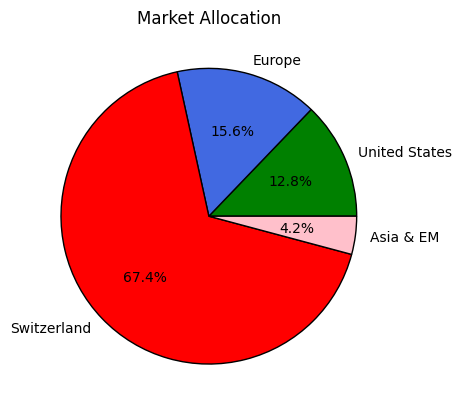

In [45]:
# IMPLEMENTED

# Allokation visualiseren
market_colors = {
    'United States':'green',
    'Europe':'royalblue',
    'Switzerland':'red',
    'Asia & EM':'pink'
}

sector_colors= {}

market_label_list = []
market_size_list = []
market_color_list = []
for market in market_allocation:
    if market_allocation[market] != 0:
        market_label_list.append(market)
        market_size_list.append(market_allocation[market])
        market_color_list.append(market_colors[market])

plt.pie(x=market_size_list, labels=market_label_list, autopct='%1.1f%%', colors=market_color_list, wedgeprops=dict(edgecolor='black'))
plt.title('Market Allocation')
plt.show()

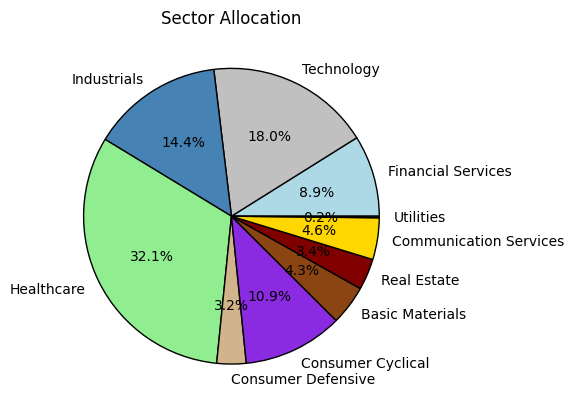

In [46]:
# IMPLEMENTED

# Allokation visualiseren

sector_colors = {
    'Financial Services':'lightblue', 
    'Technology':'silver', 
    'Industrials':'steelblue', 
    'Energy':'orange', 
    'Healthcare':'lightgreen', 
    'Consumer Defensive':'tan', 
    'Consumer Cyclical':'blueviolet', 
    'Basic Materials':'saddlebrown', 
    'Real Estate':'maroon', 
    'Communication Services':'gold', 
    'Utilities':'teal'
}

sector_label_list = []
sector_size_list = []
sector_color_list = []
for sector in sector_allocation:
    if sector_allocation[sector] != 0:
        sector_label_list.append(sector)
        sector_size_list.append(sector_allocation[sector])
        sector_color_list.append(sector_colors[sector])

plt.pie(x=sector_size_list, labels=sector_label_list, autopct='%1.1f%%', colors=sector_color_list, wedgeprops=dict(edgecolor='black'))
plt.title('Sector Allocation')
plt.show()

In [47]:
# referenz-allokation laden
profile = 'swiss-bias'
with open(f'..\data\profile_{profile}.json') as json_file:
    reference_allocation = json.load(json_file)
    print("Type:", type(reference_allocation))

Type: <class 'dict'>


In [48]:
# json-file laden
with open(f'..\data\dummy_portfolio.json') as json_file:
    dummy_portfolio = json.load(json_file)
    print("Type:", type(dummy_portfolio))

Type: <class 'dict'>


In [49]:
print(dummy_portfolio)

{'id': '000001', 'name': 'John Doe', 'investor_type': 'Swiss-Bias', 'portfolio': [{'name': 'ABB', 'isin': 'CH0012221716', 'quantity': 10}, {'name': 'Ralp Lauren', 'isin': 'US7512121010', 'quantity': 15}], 'banker': [{'name': 'UBS', 'isin': 'CH0244767585', 'quantity': 10}, {'name': 'Zurich', 'isin': 'CH0011075394', 'quantity': 15}], 'tech_guy': [{'name': 'Apple', 'isin': 'US0378331005', 'quantity': 10}, {'name': 'Microsoft', 'isin': 'US5949181045', 'quantity': 15}], 'bad_stocks': [{'isin': 'CH0012221716'}, {'isin': 'US7512121010'}], 'market_allocation': {'USA': 0.5, 'Europe': 0.0, 'Switzerland': 0.5, 'Asia & EM': 0.0}, 'sector_allocation': {'Financial Services': 0.01, 'Technology': 0.01, 'Industrials': 0.01, 'Energy': 0.01, 'Healthcare': 0.01, 'Consumer Defensive': 0.01, 'Consumer Cyclical': 0.01, 'Basic Materials': 0.01, 'Real Estate': 0.01, 'Communication Services': 0.01, 'Utilities': 0.01}, 'market_allocation_difference': {'USA': 0.35, 'Europe': -0.1, 'Switzerland': -0.2, 'Asia & EM'

In [50]:
# IMPLEMENTIERT
# stock-info laden
stock_info = pd.read_csv('..\data\stock_info.tsv', sep='\t')
# stock_info['isin'].head()
stock_info['longName'].head()
stock_info['industry'].head(10)

0      Electrical Equipment & Parts
1    Medical Instruments & Supplies
2     Building Products & Equipment
3               Specialty Chemicals
4                Building Materials
5    Integrated Freight & Logistics
6                 Computer Hardware
7            Diagnostics & Research
8                    Packaged Foods
9      Drug Manufacturers - General
Name: industry, dtype: object

In [51]:
print(stock_info.columns)

Index(['address1', 'city', 'zip', 'country', 'phone', 'fax', 'website',
       'industry', 'industryKey', 'industryDisp',
       ...
       'shortPercentOfFloat', 'totalAssets', 'navPrice', 'beta3Year',
       'fundFamily', 'fundInceptionDate', 'legalType', 'yield', 'ytdReturn',
       'threeYearAverageReturn'],
      dtype='object', length=146)


In [52]:
azn_info = stock_info.loc[stock_info['isin']=='GB0009895292']
print(f'{azn_info["longName"]}')
print(f'{azn_info["previousClose"]}')
print(f'{azn_info["currency"]}')

67    AstraZeneca PLC
Name: longName, dtype: object
67    11270.0
Name: previousClose, dtype: float64
67    GBp
Name: currency, dtype: object


In [53]:
# test-portfolio
portfolio = []
isin_list = ['CH0038863350', 'US4581401001', 'CH0009002962', 'DE000A1EWWW0', 'FR0000120073', 'NL0010273215', 'GB00B7KR2P84', 'JE00B4T3BW64', 'LU0480132876', 'HK0000069689', 'KYG017191142', 'GB0005405286', 'KYG6427A1022', 'KR7005930003', 'TW0002330008', 'NL0011585146', 'JP3732000009']
quantity_list = [10, 30, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# quantity_list = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

for i in range(len(isin_list)):
    portfolio.append({'isin':isin_list[i], 'quantity':quantity_list[i]})
portfolio

[{'isin': 'CH0038863350', 'quantity': 10},
 {'isin': 'US4581401001', 'quantity': 30},
 {'isin': 'CH0009002962', 'quantity': 15},
 {'isin': 'DE000A1EWWW0', 'quantity': 1},
 {'isin': 'FR0000120073', 'quantity': 2},
 {'isin': 'NL0010273215', 'quantity': 3},
 {'isin': 'GB00B7KR2P84', 'quantity': 4},
 {'isin': 'JE00B4T3BW64', 'quantity': 5},
 {'isin': 'LU0480132876', 'quantity': 6},
 {'isin': 'HK0000069689', 'quantity': 7},
 {'isin': 'KYG017191142', 'quantity': 8},
 {'isin': 'GB0005405286', 'quantity': 9},
 {'isin': 'KYG6427A1022', 'quantity': 10},
 {'isin': 'KR7005930003', 'quantity': 11},
 {'isin': 'TW0002330008', 'quantity': 12},
 {'isin': 'NL0011585146', 'quantity': 13},
 {'isin': 'JP3732000009', 'quantity': 14}]

In [54]:
# IMPLEMENTIERT

# Kaufen
isin = 'US123'
quantity = 5

print(f"Buying {quantity} units of ISIN {isin}...")

# Checken, ob bereits im portfolio
already_bought = False
for i in range(len(portfolio)):
    if portfolio[i]['isin'] == isin:
        already_bought = True
        print(f"Position already in Portfolio, increasing quantity by {quantity}.")
        portfolio[i]['quantity'] += quantity
        print(f'Updated Position: {portfolio[i]["quantity"]} units of ISIN {portfolio[i]["isin"]}')
        break
if already_bought == False:
    portfolio.append({'isin':isin, 'quantity':quantity})
    print(f'New Position.\nSuccessfully bought {quantity} units of ISIN {isin}.')

print(f'Purchase successfully completed!')



# portfolio.append({'isin':'CH0038863350', 'quantity':5})

Buying 5 units of ISIN US123...
New Position.
Successfully bought 5 units of ISIN US123.
Purchase successfully completed!


In [55]:
# IMPLEMENTIERT
# mit portfolio-positionen die daten aus stock-data holen für allokation

europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland']
asia_stocks = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan']

portfolio_currency = 'CHF'
forex = {
    'CHF':1.,
    'EUR':0.9549,
    'USD':0.9023,
    'GBp':1.0953, # achtung, yfinance nutzt lowercase p
    'GBP':1.0953,
    'NOK':0.0808,
    'JPY':0.00603,
    'HKD':0.1153,
    'KRW':0.00067,
    'TWD':0.0278
}

portfolio_value = 0 # variable für gesamtwert des portfolios
for position in portfolio:
    # relevante Infos fetchen
    info = stock_info.loc[stock_info['isin'] == position['isin'], ['isin', 'longName', 'previousClose', 'currency', 'country' , 'sector']] # zeile aus stock-info von dieser Aktie
    
    position['name'] = info['longName'].values[0]       # Name
    position['price'] = info['previousClose'].values[0] # Preis
    position['currency'] = info['currency'].values[0]   # Währung
    position['value'] = round(position['quantity']*position['price']*forex[position['currency']], 2) # Wert = Anzahl*Preis*Wechselkurs
    portfolio_value += position['value']    # Portfoliowert aktualisieren
    position['country'] = info['country'].values[0]     # Land

    # Region für Allokation
    if position['country'] in europe_countries:
        position['region'] = 'Europe'
    elif position['country'] in asia_stocks:
        position['region'] = 'Asia'
    else:
        position['region'] = position['country']
    position['sector'] = info['sector'].values[0]

# Anteil am Portfoliowert für jede Position
for position in portfolio:
    position['portfolio_percent'] = round(position['value']/portfolio_value, 4)
    
print(portfolio_value)
print(portfolio)
# print(portfolio)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
testy = 0
for i in range(len(portfolio)):
    print(portfolio[i]['value'])
    testy += portfolio[i]['value']
print(f'Portfolio Value: {testy}')

1034.2
989.64
20745.0
163.25
304.31
1641.19
1711.3
2534.8
517.62
56.01
75.64
6437.08
188.52
511.48
183.81
3695.39
141.11


KeyError: 'value'

In [ ]:
testy2 = 0
for i in range(len(portfolio)):
    print(portfolio[i]['portfolio_percent'])
    testy2 += portfolio[i]['portfolio_percent']
print(f'Portfolio Total Percent: {testy2}')

KeyError: 'portfolio_percent'

In [ ]:
countries = []
for i in range(len(stock_info)):
    if stock_info['country'][i] not in countries:
        countries.append(stock_info['country'][i])
countries

['Switzerland',
 nan,
 'Germany',
 'France',
 'Netherlands',
 'Spain',
 'Italy',
 'United Kingdom',
 'Norway',
 'United States',
 'Ireland',
 'Japan',
 'Hong Kong',
 'China',
 'South Korea',
 'Taiwan']

In [ ]:
currencies = []
for i in range(len(stock_info)):
    if stock_info['currency'][i] not in currencies:
        currencies.append(stock_info['currency'][i])
currencies

['CHF', 'EUR', 'USD', 'GBp', 'NOK', 'JPY', 'HKD', 'KRW', 'TWD']

In [ ]:
europe_countries = ['Germany', 'France', 'Netherlands', 'Spain', 'Italy', 'United Kingdom', 'Norway', 'Ireland']
asia_stocks = ['Japan', 'Hong Kong', 'China', 'South Korea', 'Taiwan']

In [ ]:
# Titel ohne country
stock_info[stock_info['country'].isna()]['longName']

24                                      Georg Fischer AG
75     Compagnie Générale des Établissements Michelin...
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
Name: longName, dtype: object

In [ ]:
stock_info[stock_info['sector'].isna()]['isin']

24     CH1169151003
75     FR001400AJ45
110    LU0480132876
111    LU1169822779
Name: isin, dtype: object

In [ ]:
stock_info[stock_info['previousClose'].isna()]['longName']

Series([], Name: longName, dtype: object)

In [ ]:
stock_info[stock_info['industry'].isna()]['longName']

24                                      Georg Fischer AG
75     Compagnie Générale des Établissements Michelin...
110    UBS (Lux) Fund Solutions – MSCI Emerging Marke...
111      UBS (Lux) Fund Solutions – MSCI Japan UCITS ETF
Name: longName, dtype: object

In [ ]:
stock_info[stock_info['industry'].isna()]['dividendYield']

24    NaN
75    NaN
110   NaN
111   NaN
Name: dividendYield, dtype: float64

In [ ]:
stock_info.loc[stock_info['isin'] == 'CH0038863350', ['dividendYield']]

,dividendYield
8,0.0286


In [ ]:
stock_info.loc[stock_info['isin'] == 'CH0319416936', ['52WeekChange']]

,52WeekChange
22,0.135099


In [ ]:
stock_info.loc[stock_info['isin'] == 'CH0012221716', ['previousClose']]

,previousClose
0,32.66


In [ ]:
nesn_data = stock_info.loc[stock_info['isin'] == 'CH0038863350', ['isin', 'longName', 'previousClose', 'sector', 'ytdReturn']]
nesn_data


,isin,longName,previousClose,sector,ytdReturn
8,CH0038863350,Nestlé S.A.,103.42,Consumer Defensive,NaN


In [ ]:
info = stock_info.loc[stock_info['isin'] == portfolio[0]['isin']]
info

,address1,city,zip,country,phone,fax,website,industry,industryKey,industryDisp,...,shortPercentOfFloat,totalAssets,navPrice,beta3Year,fundFamily,fundInceptionDate,legalType,yield,ytdReturn,threeYearAverageReturn
8,avenue NestlE 55,Vevey,1800,Switzerland,41 21 924 11 11,NaN,https://www.nestle.com,Packaged Foods,packaged-foods,Packaged Foods,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Klasse: investor
Attribut:
portfolio isch s dictionary mit beliebig viel key:value paar wo sind ISIN:Anzahl_Aktien (CH0038863350:1400) <-- er het 1400x nestlé aktia
bad_stocks: a lista mit allna aktia wo de CIO uf "SELL" het (warnig für da user, dass er dia söll wegtua)
market_allocation isch s dictionary mit da vier märkt als key und deren %-Anteil als Value (Europe:20%)
sector_allocation: same, aber mit industriesektora (Tech:8%)
investor_type: uswahl vo eina vo da drei muster-allokationa (Swiss-Bias, Swiss-Global, Global)
market_allocation_difference: dictionary wo d unterschied zwüschet de allocation vom investor und de muster-allokation drin isch (investor het 5% USA und s muster het 35% USA -->  USA:-30%)
sector_allocation_difference: same mit sektora
Funktiona:
calculate_allocation: berechnig vo de market_allocation und de sector_allocation anhand vo sinem portfolio
calculate_allocation_differences: berechnig vo market_allocation_difference und sector_allocation_difference
find_bad_stocks: im portfolio d aktia ablicha mit de CIO lista vo "SELL" aktia, und wenn ma eini findet schribt ma sie in bad_stocks lista
buy(ISIN, Anzahl): a aktia ins portfolio kaufa
random_portfolio: portfolio fülla mit ca. 15-25 Aktia, jewiils 15'000 bis 150'000 Franka. ich glaub es söll sich a chli am investor_type usrichta, aber dörf ruhig recht random sii macht eifach das 15-25x:    random aktia ussuacha, random betrag bestimma (15-150k), betrag//(Wert vo 1 Aktia) <-- ganzzahldivision, wia viel stück ma kauft, funktion buy(ISIN, Anzahl) ufrüafa
write_JSON: pack d dictionaries in es JSON (fürs frontend) (bearbeitet)

In [ ]:
from pandas_datareader import data,wb
from datetime import date
import pandas as pd

In [ ]:
startdate = pd.to_datetime('2023-11-02')
enddate = pd.to_datetime(date.today())
data.DataReader("AAPL", 'stooq',startdate, enddate)

,Open,High,Low,Close,Volume
Date,,,,,
2023-11-03,174.24,176.82,173.35,176.65,79829246
2023-11-02,175.52,177.78,175.46,177.57,77334752


In [ ]:
alpha_vantage_api_key = 'GXFEHFO0WL18N13F'

In [ ]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=alpha_vantage_api_key)
# Get json object with the intraday data and another with  the call's metadata
data, meta_data = ts.get_intraday('GOOG')

In [ ]:
meta_data

{'1. Information': 'Intraday (15min) open, high, low, close prices and volume',
 '2. Symbol': 'GOOG',
 '3. Last Refreshed': '2023-11-03 19:45:00',
 '4. Interval': '15min',
 '5. Output Size': 'Compact',
 '6. Time Zone': 'US/Eastern'}

In [ ]:
import investpy

In [ ]:
available_equities = investpy.get_equities_list()

AttributeError: module 'investpy' has no attribute 'get_equities_list'

In [ ]:
nasdaq_api_key = 'sXV3J9sAzYqULxYcUkac'

In [ ]:
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = nasdaq_api_key
mydata = nasdaqdatalink.get("WIKI/AAPL", rows=5)

In [ ]:
mydata

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,175.04,175.09,171.26,171.270,35247358.0,0.0,1.0,175.04,175.09,171.26,171.270,35247358.0
2018-03-22,170.00,172.68,168.60,168.845,41051076.0,0.0,1.0,170.00,172.68,168.60,168.845,41051076.0
2018-03-23,168.39,169.92,164.94,164.940,40248954.0,0.0,1.0,168.39,169.92,164.94,164.940,40248954.0
2018-03-26,168.07,173.10,166.44,172.770,36272617.0,0.0,1.0,168.07,173.10,166.44,172.770,36272617.0
2018-03-27,173.68,175.15,166.92,168.340,38962839.0,0.0,1.0,173.68,175.15,166.92,168.340,38962839.0


In [ ]:
import investpy

df = investpy.stocks.search_stocks(by='isin', value='CH0038863350')
print(df)

       country    name  full_name          isin currency symbol
0       mexico  Nestle  Nestle SA  CH0038863350      MXN  NESNN
1        italy  Nestle  Nestle SA  CH0038863350      EUR   NESN
2  switzerland  Nestle  Nestle SA  CH0038863350      CHF   NESN


In [ ]:
investpy.stocks.search_stocks(by='isin', value='JP3436100006')

,country,name,full_name,isin,currency,symbol
0,japan,Softbank Group Corp.,Softbank Group Corp.,JP3436100006,JPY,9984


In [ ]:
investpy.stocks.search_stocks(by='isin', value='US0378331005')

,country,name,full_name,isin,currency,symbol
0,mexico,Apple,Apple Inc,US0378331005,MXN,AAPL
1,united states,Apple,Apple Inc,US0378331005,USD,AAPL
2,austria,Apple,Apple Inc,US0378331005,EUR,AAPL
3,italy,Apple,Apple Inc,US0378331005,EUR,AAPLE
4,switzerland,Apple,Apple Inc,US0378331005,EUR,AAPLEUR
5,switzerland,Apple,Apple Inc,US0378331005,USD,AAPLUSD
6,switzerland,Apple,Apple Inc,US0378331005,CHF,AAPL


In [ ]:
investpy.stocks.get_stock_information(stock='AAPL', country='united states')

ConnectionError: ERR#0015: error 403, try again later.

In [ ]:
investpy.stocks.search_stocks(by='full_name', value='nestle sa')

,country,name,full_name,isin,currency,symbol
0,mexico,Nestle,Nestle SA,CH0038863350,MXN,NESNN
1,united states,Nestle ADR,Nestle SA ADR,US6410694060,USD,NSRGY
2,italy,Nestle,Nestle SA,CH0038863350,EUR,NESN
3,switzerland,Nestle,Nestle SA,CH0038863350,CHF,NESN
4,switzerland,Nestle,Nestle SA,CH0372071347,CHF,NESNEE


In [ ]:
print('Quotes:\n')
quotes = yf.download('CH0038863350', period = '1d')
# quotes = yf.download()
print(quotes)

Quotes:

[*********************100%%**********************]  1 of 1 completed
                  Open        High        Low  Close  Adj Close   Volume
Date                                                                    
2023-11-03  100.519997  100.599998  99.739998  99.75      99.75  1946070
